In [20]:
import numpy as np
import matplotlib.pyplot as plt
import cv2
import argparse
import os
from skimage.feature import peak_local_max
import copy

In [93]:
filepath = r"C:\Users\siddh\Documents\733\Panoroma_Stitching\TraditionalWay"
imagesFolder = r"Data\Train\Set1"
saveFolder = r"Results\Set1"
showImages = True
useHarris = False
choice = 1 if useHarris else 2 # shi-Tomashi , 1 for Harris corner

In [94]:
# read the images
def readImages(filepath: str):
    print('Reading from: ', filepath)
    images = []
    files = os.listdir(filepath)
    sorted(files)
    for file in files:
        imagePath = os.path.join(filepath, file)
        image = cv2.imread(imagePath)
        if image is not None:
            images.append(image)
    print('Read ', len(images), ' images')
    return images

In [95]:
def makeImagesSizeSame(images:list[np.ndarray])->list[np.ndarray]:
    sizeList = []
    for image in images:
        x, y, ch = image.shape
        sizeList.append([x, y, ch])
    sizeArr = np.array(sizeList)
    r, c, ch = np.max(sizeArr, axis=0)
    newImages = []
    for i, image in enumerate(images):
        resized = np.zeros((r, c, sizeArr[i, 2]), np.uint8)
        resized[0:sizeArr[i, 0], 0:sizeArr[i, 1], 0:sizeArr[i, 2]] = image
        newImages.append(resized)
    return newImages
    

In [64]:
def displayImages(images:list[np.ndarray], fileName:str):
    newImages = makeImagesSizeSame(images)
    concatenated = newImages[0].copy()
    for i in range(1, len(newImages)):
        concatenated = np.concatenate((concatenated, newImages[i]), axis=1)
    cv2.imshow(fileName, concatenated)
    cv2.waitKey()
    cv2.destroyAllWindows()
    print('Writing file to ', fileName)
    cv2.imwrite(fileName, concatenated)    

In [96]:
images = readImages(os.path.join(filepath, imagesFolder))
if showImages:
    displayImages(images, os.path.join(filepath, saveFolder, 'concatenated.png'))

Reading from:  C:\Users\siddh\Documents\733\Panoroma_Stitching\TraditionalWay\Data\Train\Set1
Read  3  images
Writing file to  C:\Users\siddh\Documents\733\Panoroma_Stitching\TraditionalWay\Results\Set1\concatenated.png


In [97]:
def detectCorners(images:list[np.ndarray], choice:int):
    print('Detecting Corners...')
    detectedCorners = []
    cmaps = []
    corner_images = []
    for image in images:
        gray_image = cv2.cvtColor(image,cv2.COLOR_BGR2GRAY)
        if choice == 1:
            print("Harris corner detection method.")
            corner_strength = cv2.cornerHarris(gray_image,2,3,0.001)
            corner_strength[corner_strength<0.01*corner_strength.max()] = 0
            cmaps.append(corner_strength)
            detected_corner = np.where(corner_strength>0.0001*corner_strength.max())
            detectedCorners.append(detected_corner)
            image[detected_corner] = [0,0,255]
            corner_images.append(image)
        else:
            print("Shi-Tomashi corner detection method.")
            dst = cv2.goodFeaturesToTrack(gray_image, 1000 ,0.01, 10)
            dst = np.int0(dst)
            detectedCorners.append(dst)
            for corner in dst:
                x, y = corner.ravel()
                cv2.circle(image, (x, y) ,3 ,(0, 0, 255), -1)
            corner_images.append(image)
            # cmap not used for shi-tomashi
            cmap = np.zeros(gray_image.shape)
            cmaps.append(cmap)
    return detectedCorners, cmaps, corner_images
            


In [98]:
def show(image):
    cv2.imshow('Image', image)
    cv2.waitKey()
    cv2.destroyAllWindows()

In [99]:
detectedCorners, cmaps, cornerImages = detectCorners(copy.deepcopy(images), choice=choice)

Detecting Corners...
Shi-Tomashi corner detection method.
Shi-Tomashi corner detection method.
Shi-Tomashi corner detection method.


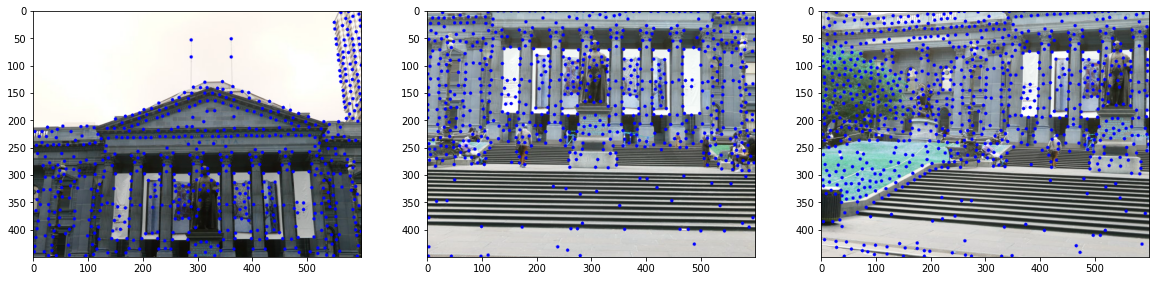

In [100]:
fig, ax = plt.subplots(1, len(cornerImages), figsize=(20,5))
for i in range(len(cornerImages)):
    ax[i].imshow(cornerImages[i])

In [72]:
def AdaptiveNonMaximalSupression(images:list[np.ndarray], Cmaps:list[np.ndarray], N_best:int):
    anms_images = []
    anms_corners = []
    for i, image in enumerate(images):
        cmap = Cmaps[i]
        local_max = peak_local_max(cmap, min_distance=15)
        n_strong = local_max.shape[0]
        r = [np.inf for i in range(n_strong)]
        dist = 0
        final = np.zeros((n_strong, 2), dtype=int)
        
        for i in range(n_strong):
            for j in range(n_strong):
                x_i = local_max[i][0]
                y_i = local_max[i][1]

                x_j = local_max[j][0]
                y_j = local_max[j][1]

                if (cmap[x_j,y_j] > cmap[x_i, y_i]):
                    dist = np.square(x_i-x_j) + np.square(y_i-y_j)
                if (dist < r[i]):
                    r[i] = dist
                    final[i, 0] = y_j
                    final[i, 1] = x_j
        
        if n_strong < N_best:
            N_best = n_strong
        index = np.argsort(r)
        index = np.flip(index)
        index = index[:N_best]
        final = final[index]
        for cx, cy in final:
            cv2.circle(image, (cx, cy), 4, (255, 0, 0), -1)
        anms_images.append(image)
        anms_corners.append(final)

    return anms_corners, anms_images

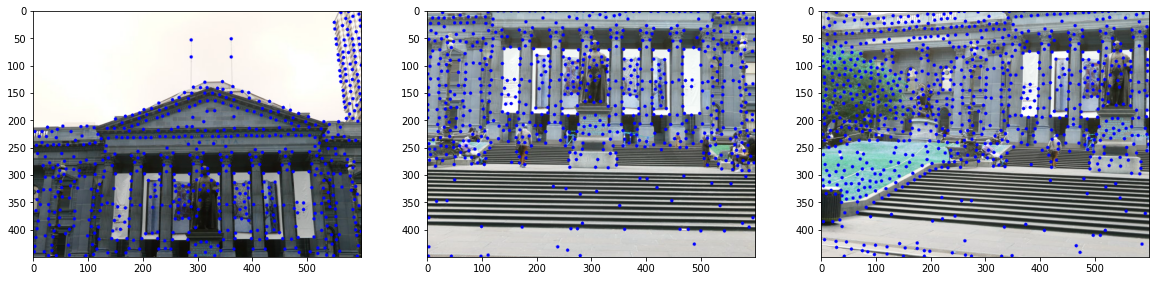

In [101]:
if (choice == 1):
    anms_corners, anms_images = AdaptiveNonMaximalSupression(copy.deepcopy(images), cmaps, 300)
else:
    anms_corners, anms_images = detectedCorners, cornerImages
fig, ax = plt.subplots(1, len(anms_images), figsize=(20,5))
for i in range(len(anms_images)):
    ax[i].imshow(anms_images[i])

In [74]:
def getFeatureDescriptor(image, col, row, path_size=40):
    patch = image[col - path_size//2: col + path_size//2 , row - path_size//2: row + path_size//2]
    # gaussian blur
    patch = cv2.GaussianBlur(patch, (3,3), 0)
    # subsample to 20%
    patch = cv2.resize(patch, None, fx=0.2, fy=0.2, interpolation=cv2.INTER_CUBIC)
    # flatten the patch
    feature = patch.reshape(-1)
    # zero mean and unit std
    feature = (feature - np.mean(feature)) / np.std(feature)
    return feature

In [75]:
def checkAndGetFeature(corners: list[np.ndarray], image:np.ndarray, patch_size=40):
    image = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    width, height = image.shape
    features = []
    final_corners = []
    for corner in corners:
        x, y = corner.ravel()
        if (x - patch_size/2 > 0 and x + patch_size/2 < height
            and y - patch_size/2 > 0 and y + patch_size/2 < width):
            features.append(getFeatureDescriptor(image, y, x, patch_size))
            final_corners.append([x, y])
    return features, final_corners
        

In [76]:
def getPairs(img1, img2, corners1, corners2, patch_size=40):
    features = []
    corners = []
    
    feature, corner = checkAndGetFeature(corners1, img1, patch_size=patch_size)
    features.append(feature)
    corners.append(corner)

    feature, corner = checkAndGetFeature(corners2, img2, patch_size=patch_size)
    features.append(feature)
    corners.append(corner)

    matched_pairs = []
    for i, feature1 in enumerate(features[0]):
        ssd = []
        for j, feature2 in enumerate(features[1]):
            ssd.append(np.sum((feature1 - feature2)**2))
        best_match = np.argmin(ssd)
        matched_pairs.append([corners[0][i], corners[1][best_match]])
    print("Matched pairs between two images: ", len(matched_pairs))
    return np.array(matched_pairs)

In [77]:
def showMatches(img1, img2, matched_pairs, filename):
    image1 = copy.deepcopy(img1)
    image2 = copy.deepcopy(img2)
    image1, image2 = makeImagesSizeSame([image1, image2])
    concat = np.concatenate((image1, image2), axis = 1)
    corners_1 = matched_pairs[:,0].copy()
    corners_2  = matched_pairs[:,1].copy()
    corners_2[:,0] += image1.shape[1]

    for (x1,y1) , (x2,y2) in zip(corners_1, corners_2):
        cv2.line(concat, (x1,y1), (x2,y2), (0, 0, 255), 1)
    cv2.imshow(filename, concat)
    cv2.waitKey() 
    cv2.destroyAllWindows()
    cv2.imwrite(filename, concat)
    return concat

In [78]:
first = 0
second = 1

Matched pairs between two images:  517


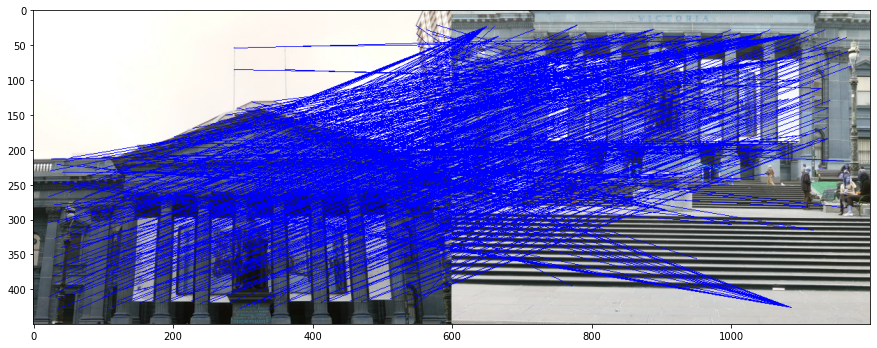

In [102]:
matched_pairs = getPairs(images[first], images[second], anms_corners[first], anms_corners[second])
matched = showMatches(images[first], images[second], matched_pairs, "matches.png")
plt.figure(figsize=(15,15))
plt.imshow(matched)

In [103]:
def calcError(set1: np.ndarray, set2:np.ndarray):
    return np.linalg.norm(set1-set2, axis=1)

In [104]:
def filterOutliers(matched_pairs:np.ndarray, threshold=5):
    set1 = matched_pairs[:, 0]
    set2 = matched_pairs[:, 1]
    N_best = -np.inf
    H_best = np.zeros((3,3))
    iterations = 5000
    threshold = 5
    best_matches = []
    for i in range(iterations):
        # randomly select 4 rows
        n_rows = set1.shape[0]
        random_idx = np.random.choice(n_rows, size=4)
        set1_random = set1[random_idx]
        set2_random = set2[random_idx]

        #compute Homography
        H = cv2.getPerspectiveTransform(np.float32(set1_random), np.float32(set2_random))
        
        # multiply with the source point to predict the target
        set1_dash = np.vstack((set1[:,0], set1[:,1], np.ones((1, n_rows))))
        set2_pred = np.dot(H, set1_dash)
        x_pred = set2_pred[0, :] / (set2_pred[2, :] + 1e-10)
        y_pred = set2_pred[1, :] / (set2_pred[2, :] + 1e-10)
        set2_pred = np.array([x_pred, y_pred]).T
        E = calcError(set2_pred, set2)
        E[E <= threshold] = 1
        E[E > threshold] = 0
        N = np.sum(E)
        if N > N_best:
            N_best = N
            H_best = H
            best_matches = np.where(E == 1)
        
    final_set1 = set1[best_matches]
    final_set2 = set2[best_matches]

    print("Final Good Matches: ", final_set1.shape[0])

    final_matches = np.zeros((final_set1.shape[0], 2, 2))
    # match from 1st image
    final_matches[:, 0, :] = final_set1
    # correspondence in 2nd image
    final_matches[:, 1, :] = final_set2
    final_matches = final_matches.astype(int)

    return H_best, final_matches

Final Good Matches:  213


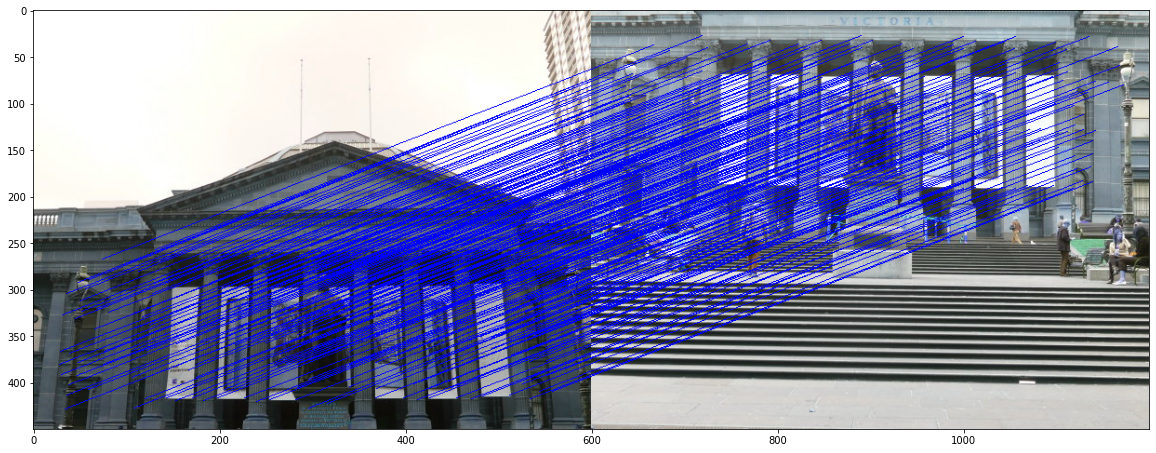

In [105]:
H, final_matches = filterOutliers(matched_pairs, threshold=5)
img_match = showMatches(images[first], images[second], final_matches, "final matches.png")
plt.figure(figsize=(20,20))
plt.imshow(img_match)


In [106]:
image0 = copy.deepcopy(images[first])
image1 = copy.deepcopy(images[second])

#stitch image 0 on image 1
print("shapes")
print(image0.shape)
print(image1.shape)

h0 ,w0 ,_ = image0.shape
h1 ,w1 ,_ = image1.shape

points_on_image0 = np.float32([[0, 0], [0, h0], [w0, h0], [w0, 0]]).reshape(-1,1,2)
points_on_image0_transformed = cv2.perspectiveTransform(points_on_image0, H)
print("transformed points = \n", points_on_image0_transformed)
points_on_image1 = np.float32([[0, 0], [0, h1], [w1, h1], [w1, 0]]).reshape(-1,1,2)
points_on_merged_images = np.concatenate((points_on_image0_transformed, points_on_image1), axis = 0)
points_on_merged_images_ = [p.ravel() for p in points_on_merged_images]
print('Points concatenated:\n', points_on_merged_images_)


shapes
(450, 600, 3)
(450, 600, 3)
transformed points = 
 [[[-2.9362700e+01 -2.5312083e+02]]

 [[-2.8116802e-02  2.1352414e+02]]

 [[ 5.8154797e+02  2.2469559e+02]]

 [[ 6.1851331e+02 -2.4618066e+02]]]
Points concatenated:
 [array([ -29.3627 , -253.12083], dtype=float32), array([-2.8116802e-02,  2.1352414e+02], dtype=float32), array([581.548  , 224.69559], dtype=float32), array([ 618.5133 , -246.18066], dtype=float32), array([0., 0.], dtype=float32), array([  0., 450.], dtype=float32), array([600., 450.], dtype=float32), array([600.,   0.], dtype=float32)]


In [107]:
x_min, y_min = np.int0(np.min(points_on_merged_images_, axis = 0))
x_max, y_max = np.int0(np.max(points_on_merged_images_, axis = 0))

print('Min points: ', x_min, y_min)
print('Max points: ', x_max, y_max)

Min points:  -29 -253
Max points:  618 450


In [108]:
# translate to avoid negative values
H_translate = np.array([[1, 0, -x_min], [0, 1, -y_min], [0, 0, 1]])
H_final = np.dot(H_translate, H)

# warp prespective
image0_transformed_and_stitched = cv2.warpPerspective(image0, np.dot(H_translate, H), (x_max-x_min, y_max-y_min))

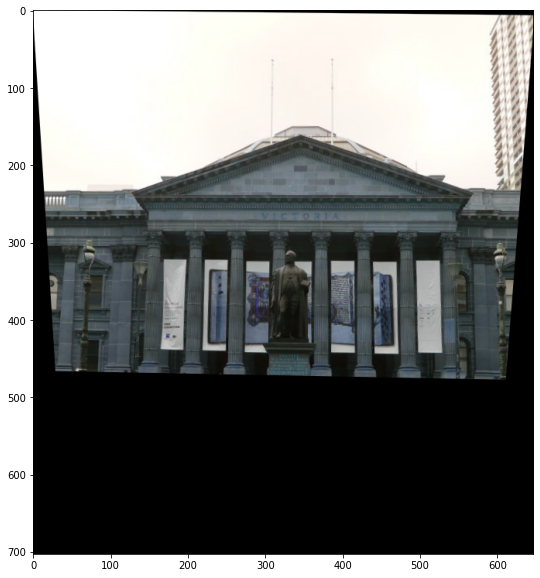

In [109]:
plt.figure(figsize=(10,10))
plt.imshow(image0_transformed_and_stitched)

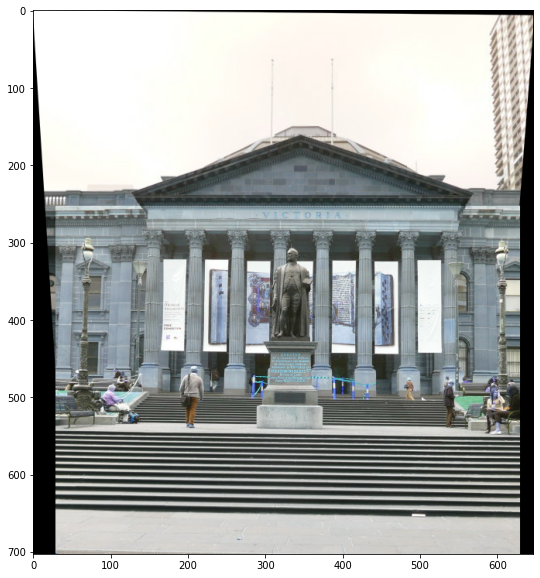

In [110]:
images_stitched = image0_transformed_and_stitched.copy()
# add in second image
images_stitched[-y_min:-y_min+h1, -x_min: -x_min+w1] = image1
show(images_stitched)
plt.figure(figsize=(10,10))
plt.imshow(images_stitched)

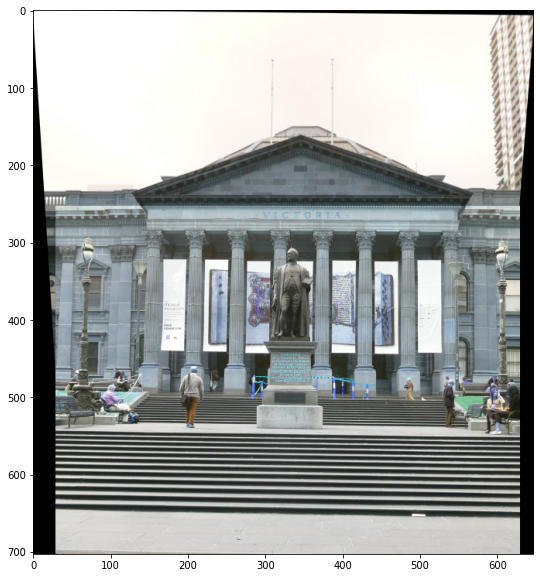

In [111]:
# fill in black spaces in second image (if any)
indices = np.where(image1 == [0,0,0])
# translate y, x from 2nd image to 1st image
y = indices[0] + -y_min 
x = indices[1] + -x_min 
# fill in from the 1st image
images_stitched[y,x] = image0_transformed_and_stitched[y,x]
show(images_stitched)
plt.figure(figsize=(10,10))
plt.imshow(images_stitched)

In [87]:
def cropImageRect(image):
    
    img = image.copy()
    gray = cv2.cvtColor(img,cv2.COLOR_BGR2GRAY)

    # threshold to get the edges in image
    _,thresh = cv2.threshold(gray,5,255,cv2.THRESH_BINARY)
    kernel = np.ones((5,5), np.uint8)
    thresh = cv2.morphologyEx(thresh, cv2.MORPH_CLOSE, kernel)
    thresh = cv2.morphologyEx(thresh, cv2.MORPH_OPEN, kernel)
    
    test = copy.deepcopy(image)
    # get the outer contour over the image
    contours, _ = cv2.findContours(thresh, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    cv2.drawContours(test, contours, -1, (0,255,0), 3)
    plt.imshow(test)

    x,y,w,h = cv2.boundingRect(contours[len(contours)-1])
    crop = img[y:y+h,x:x+w]

    return crop

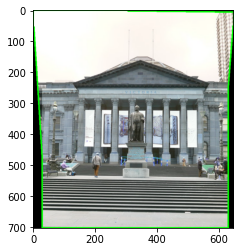

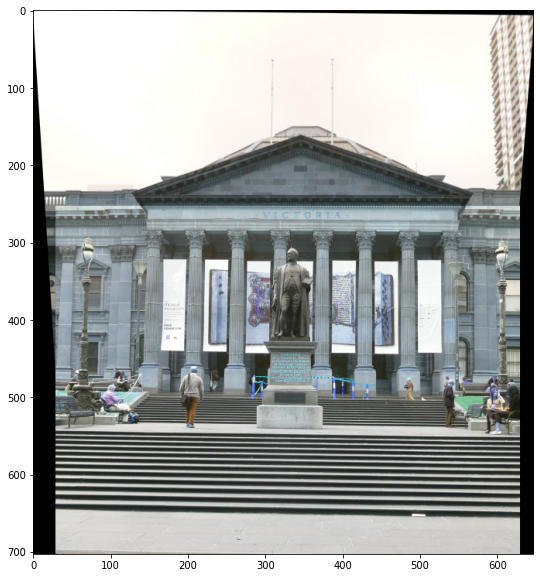

In [112]:
images_stitched = cropImageRect(images_stitched)
show(images_stitched)
plt.figure(figsize=(10,10))
plt.imshow(images_stitched)

In [89]:
def stitchImagePairs(img0, img1, H):
    image0 = copy.deepcopy(img0)
    image1 = copy.deepcopy(img1)

    #stitch image 0 on image 1
    print("shapes")
    print(image0.shape)
    print(image1.shape)

    h0 ,w0 ,_ = image0.shape
    h1 ,w1 ,_ = image1.shape

    points_on_image0 = np.float32([[0, 0], [0, h0], [w0, h0], [w0, 0]]).reshape(-1,1,2)
    points_on_image0_transformed = cv2.perspectiveTransform(points_on_image0, H)
    print("transformed points = \n", points_on_image0_transformed)
    points_on_image1 = np.float32([[0, 0], [0, h1], [w1, h1], [w1, 0]]).reshape(-1,1,2)
    points_on_merged_images = np.concatenate((points_on_image0_transformed, points_on_image1), axis = 0)
    points_on_merged_images_ = [p.ravel() for p in points_on_merged_images]
    # print('Points concatenated:\n', points_on_merged_images_)

    x_min, y_min = np.int0(np.min(points_on_merged_images_, axis = 0))
    x_max, y_max = np.int0(np.max(points_on_merged_images_, axis = 0))

    print('Min points: ', x_min, y_min)
    print('Max points: ', x_max, y_max)

    # translate to avoid negative values
    H_translate = np.array([[1, 0, -x_min], [0, 1, -y_min], [0, 0, 1]])
    H_final = np.dot(H_translate, H)

    # warp prespective
    image0_transformed_and_stitched = cv2.warpPerspective(image0, np.dot(H_translate, H), (x_max-x_min, y_max-y_min))

    plt.figure(figsize=(10,10))
    plt.imshow(image0_transformed_and_stitched)

    images_stitched = image0_transformed_and_stitched.copy()
    # add in second image
    images_stitched[-y_min:-y_min+h1, -x_min: -x_min+w1] = image1
    show(images_stitched)
    plt.figure(figsize=(10,10))
    plt.imshow(images_stitched)

    # fill in black spaces in second image (if any)
    indices = np.where(image1 == [0,0,0])
    # translate y, x from 2nd image to 1st image
    y = indices[0] + -y_min 
    x = indices[1] + -x_min 
    # fill in from the 1st image
    images_stitched[y,x] = image0_transformed_and_stitched[y,x]
    show(images_stitched)
    plt.figure(figsize=(10,10))
    plt.imshow(images_stitched)

    return images_stitched
    

In [90]:
def joinImages(img_array, choice, save_folder_name, n, show_steps = True):

    image_array = img_array.copy()
    N = len(image_array)
    image0 = image_array[0]
    j = 0
    for i in range(1, N):
        j = j + 1
        print("processing image ", i)
        image1 = image_array[i] 

        image_pair = [image0, image1]
        
        detected_corners, cmaps, corner_images = detectCorners(copy.deepcopy(image_pair), choice)
        if show_steps:
            displayImages(copy.deepcopy(corner_images), os.path.join(save_folder_name, "corners"+str(n)+str(j)+".png"))
        """
        Perform ANMS: Adaptive Non-Maximal Suppression
        Save ANMS output as anms.png
        """
        if (choice == 1):
            print("Applying ALMS.")
            detected_corners, anms_image = AdaptiveNonMaximalSupression(copy.deepcopy(corner_images), cmaps, 300)
            if show_steps:
                displayImages(copy.deepcopy(anms_image), os.path.join(save_folder_name, "anms_output"+str(n)+str(j)+".png"))
        else:
            print("goodFeaturesToTrack is already using ALMS.") #review

        detected_corners0 = detected_corners[0]
        detected_corners1 = detected_corners[1]
                
        matched_pairs = getPairs(image0, image1, detected_corners0, detected_corners1, patch_size = 40)
        if show_steps:
            showMatches(image0, image1, matched_pairs, os.path.join(save_folder_name, "matched_pairs"+str(n)+str(j)+".png"))
        """
        Refine: RANSAC, Estimate Homography
        """
        H,filtered_matched_pairs = filterOutliers(matched_pairs, threshold=5)
        if show_steps:
            showMatches(image0, image1, filtered_matched_pairs, os.path.join(save_folder_name, "filtered_matched_pairs"+str(n)+str(j)+".png"))


        unique, counts = np.unique(filtered_matched_pairs[:,1,:], return_counts=True, axis = 0)
        unique_count = unique.shape[0]
        max_count = np.max(counts)

        stitching = True
        # print(unique_count, max_count)
        # if(unique_count < 7 and max_count > 8):
        #     print("Cannot match image")
        #     stitching = False
        """
        Image Warping + Blending
        Save Panorama output as mypano.png
        """
        if(stitching):
            stitched_image = stitchImagePairs(image0, image1, H)
            stitched_image = cropImageRect(stitched_image)
            if show_steps:
                cv2.imshow(os.path.join(save_folder_name, "pano"+str(n)+str(j)+".png"), stitched_image)
                cv2.waitKey() 
                cv2.destroyAllWindows()

            cv2.imwrite(os.path.join(save_folder_name, "pano"+str(n)+str(j)+".png"), stitched_image)
            image0 = stitched_image
        else:
            if show_steps:
                cv2.imshow(os.path.join(save_folder_name, "pano"+str(n)+str(j)+".png"), image0)
                cv2.waitKey() 
                cv2.destroyAllWindows()

            cv2.imwrite(os.path.join(save_folder_name, "pano"+str(n)+str(j)+".png"), image0)

    return image0

processing image  1
Detecting Corners...
Shi-Tomashi corner detection method.
Shi-Tomashi corner detection method.
Writing file to  C:\Users\siddh\Documents\733\Panoroma_Stitching\TraditionalWay\Results\Set1\corners01.png
goodFeaturesToTrack is already using ALMS.
Matched pairs between two images:  517
Final Good Matches:  213
shapes
(450, 600, 3)
(450, 600, 3)
transformed points = 
 [[[ -58.2755    -285.8828   ]]

 [[   1.9397036  217.00665  ]]

 [[ 577.5435     223.36185  ]]

 [[ 629.47906   -266.72583  ]]]
Min points:  -58 -285
Max points:  629 450


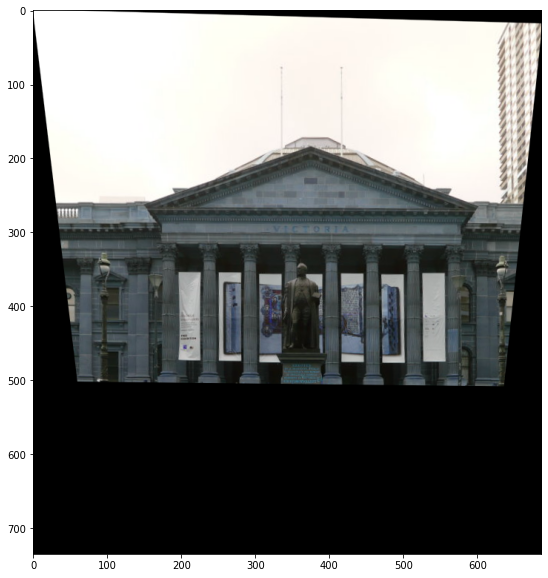

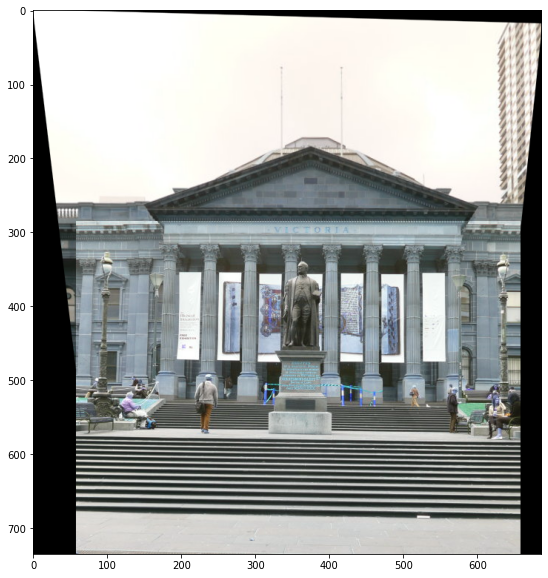

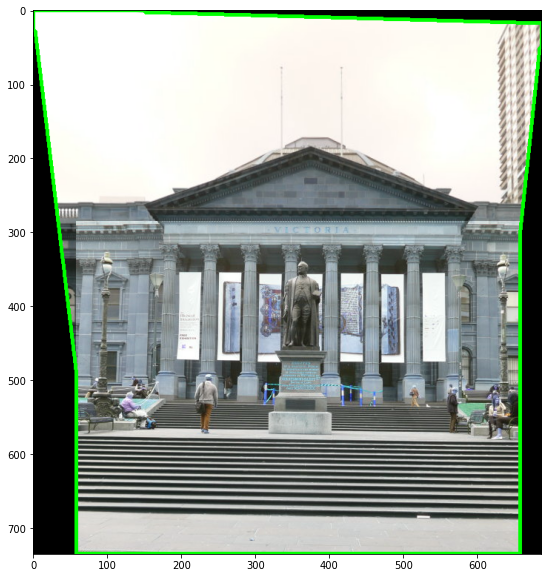

In [113]:
k = joinImages([images[0], images[1]], choice, os.path.join(filepath, saveFolder), 0, True)

processing image  1
Detecting Corners...
Shi-Tomashi corner detection method.
Shi-Tomashi corner detection method.
Writing file to  C:\Users\siddh\Documents\733\Panoroma_Stitching\TraditionalWay\Results\Set1\corners11.png
goodFeaturesToTrack is already using ALMS.
Matched pairs between two images:  714
Final Good Matches:  211
shapes
(450, 600, 3)
(735, 687, 3)
transformed points = 
 [[[-244.9996   241.38353]]

 [[-233.00818  761.2771 ]]

 [[ 417.7417   711.7538 ]]

 [[ 421.967    290.77402]]]
Min points:  -244 0
Max points:  687 761


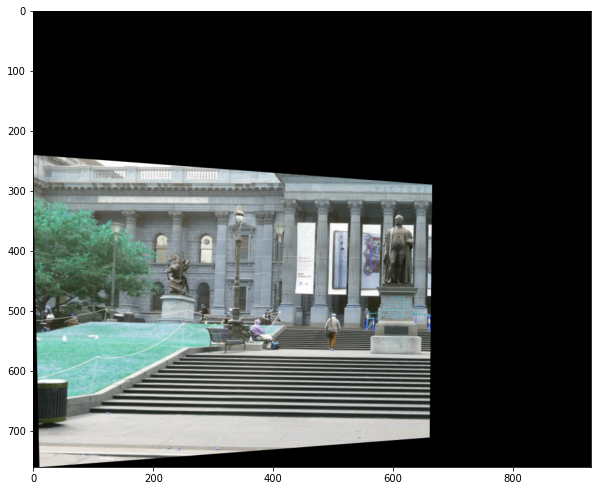

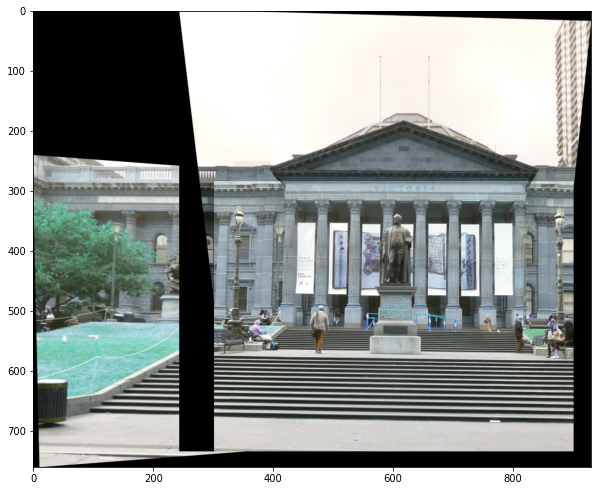

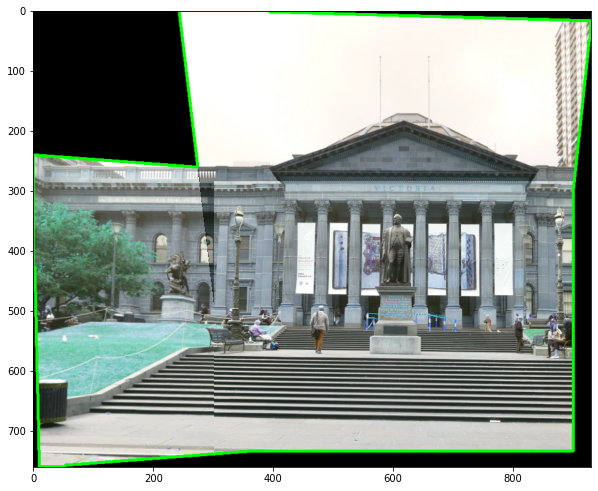

In [114]:
l = joinImages([images[2], k], choice, os.path.join(filepath, saveFolder), 1, True)

<>:10: SyntaxWarning: "is not" with a literal. Did you mean "!="?
<>:10: SyntaxWarning: "is not" with a literal. Did you mean "!="?
<>:10: SyntaxWarning: "is not" with a literal. Did you mean "!="?
<>:10: SyntaxWarning: "is not" with a literal. Did you mean "!="?
C:\Users\siddh\AppData\Local\Temp\ipykernel_25824\2224103617.py:10: SyntaxWarning: "is not" with a literal. Did you mean "!="?
  while N_images is not 2:
C:\Users\siddh\AppData\Local\Temp\ipykernel_25824\2224103617.py:10: SyntaxWarning: "is not" with a literal. Did you mean "!="?
  while N_images is not 2:


Splitting total images in sets of 2 ,and 1
processing image  1
Detecting Corners...
Shi-Tomashi corner detection method.
Shi-Tomashi corner detection method.
Writing file to  C:\Users\siddh\Documents\733\Panoroma_Stitching\TraditionalWay\Results\Set1\corners01.png
goodFeaturesToTrack is already using ALMS.
Matched pairs between two images:  517
Final Good Matches:  212
shapes
(450, 600, 3)
(450, 600, 3)
transformed points = 
 [[[ -33.77876    -264.1549    ]]

 [[  -0.95493186  215.46495   ]]

 [[ 579.64545     224.85483   ]]

 [[ 624.68024    -252.52951   ]]]
Min points:  -33 -264
Max points:  624 450
processing image  1
Detecting Corners...
Shi-Tomashi corner detection method.
Shi-Tomashi corner detection method.
Writing file to  C:\Users\siddh\Documents\733\Panoroma_Stitching\TraditionalWay\Results\Set1\corners11.png
goodFeaturesToTrack is already using ALMS.
Matched pairs between two images:  803
Final Good Matches:  214
shapes
(714, 657, 3)
(450, 600, 3)
transformed points = 
 [[[ 

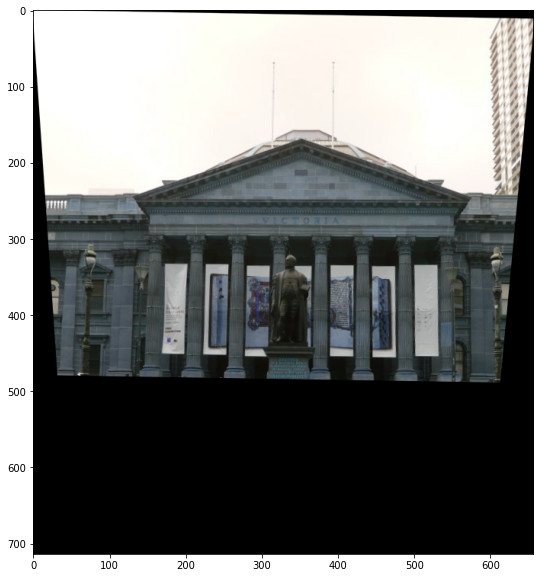

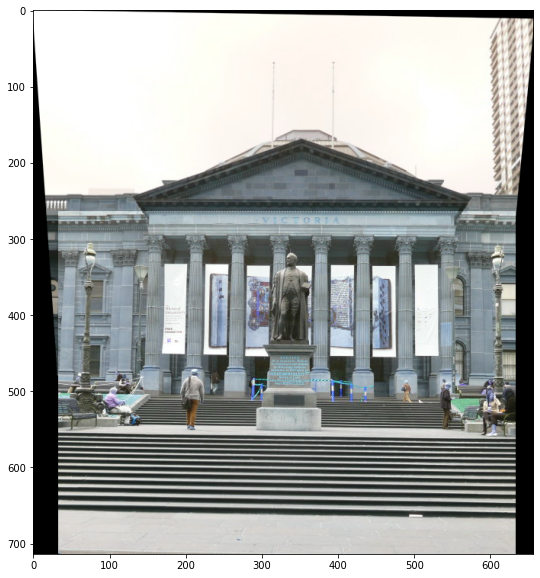

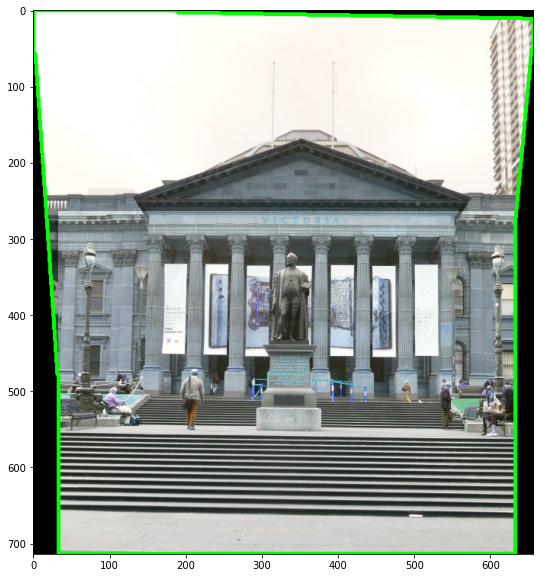

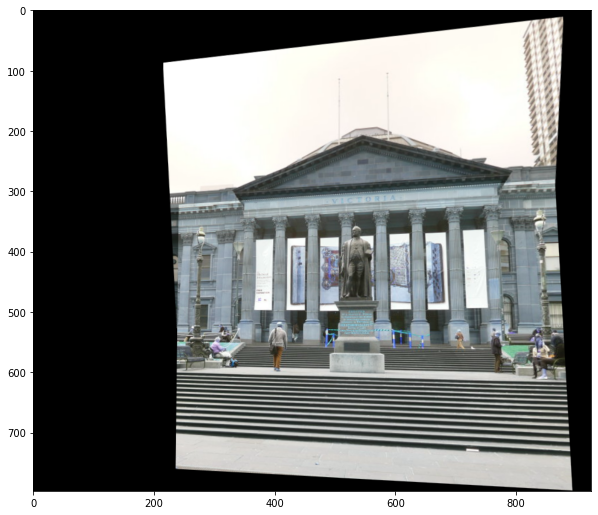

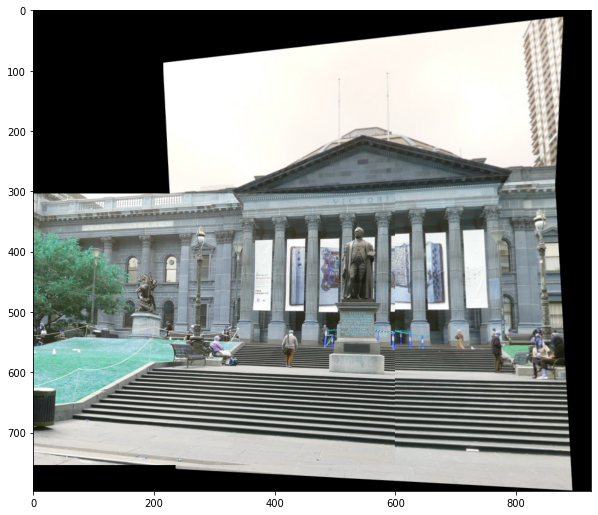

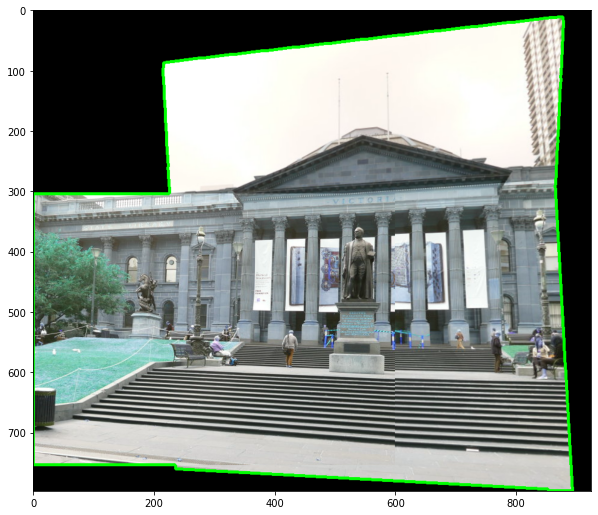

In [60]:
# total images
N_images = len(images)
# split in sets
N_first_half = round(N_images/2)
N_second_half = N_images - N_first_half
print('Splitting total images in sets of', N_first_half, ',and', N_second_half)
GoSequentially = True

if not GoSequentially:
    while N_images is not 2:
        print("N = ", N_images, " N_half = ", N_first_half)
        merged_images = []
        for n in range(0, N_first_half, 2):
            if (n+1) <= N_first_half:
                img_array = images[n:n+2]
                print("combining: ", n, n+1)
                I = joinImages(img_array, choice, os.path.join(filepath, saveFolder), n, showImages)
                merged_images.append(I)
            else:
                print("adding: ", n)
                merged_images.append(images[n])

        for n in range(N_first_half, N_images, 2):
            if (n+1) < N_images:
                img_array = images[n:n+2]
                img_array.reverse()
                print("combining: ", n+1, n)
                I = joinImages(img_array, choice, os.path.join(filepath, saveFolder), n, showImages)
                merged_images.append(I)
            else:
                print("adding: ", n)
                merged_images.append(images[n])
    
        images = merged_images
        N_images = len(images)
        N_first_half = round(N_images/2)
        N_second_half = N_images - N_first_half
    
    print("final merging")
    if N_images % 2 != 0:
        print("reversing")
        merged_images.reverse()
    final = joinImages(merged_images, choice, os.path.join(filepath, saveFolder), 100, showImages)
else:
    Image0 = images[0]
    for n in range(N_images - 1):
        img_array = [Image0, images[n+1]]
        Image0 = joinImages(img_array, choice, os.path.join(filepath, saveFolder), n, showImages)

    if showImages:
        cv2.imshow(os.path.join(filepath, saveFolder) + "/pano" + str(n) + ".png", Image0)
        cv2.waitKey() 
        cv2.destroyAllWindows()

    cv2.imwrite(os.path.join(filepath, saveFolder) + "/pano" + str(n) + ".png", Image0)
